# core

> The core of SynCMap

In [ ]:
#| default_exp core

In [ ]:
#| export
import pandas as pd

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from scipy.spatial import distance

from scipy.stats import entropy
# from sklearn.metrics import normalized_mutual_info_score

from tqdm import tqdm

import sys
# sys.path.insert(0, '../')
# 如果没有 pip install -e . 下面一行就不会成功
from SyncMap_Draft.utility import OverlapChunkTest1, to_categorical, compute_combi_dist

# from ipywidgets import widgets
# from IPython.display import display

In [ ]:
#| export
class SyncMap:
	
	def __init__(self, input_size, dimensions, adaptation_rate):
		
		self.organized= False
		self.space_size= 10
		self.dimensions= dimensions
		self.input_size= input_size
		#syncmap= np.zeros((input_size,dimensions))
		self.syncmap= np.random.rand(input_size,dimensions)
		self.adaptation_rate= adaptation_rate
		self.total_activation= np.zeros(input_size)
		#self.syncmap= np.random.rand(dimensions, input_size)
	
	def inputGeneral(self, x):
		plus= x > 0.1
		minus = ~ plus

		sequence_size = x.shape[0]
		#print(sequence_size, "asfasdfasdfasd")
		for i in range(sequence_size):
			
			vplus= plus[i,:]
			vminus= minus[i,:]
			plus_mass = vplus.sum()
			minus_mass = vminus.sum()
			self.total_activation+= vplus.astype(int)
			# self.total_activation-= vminus.astype(int)
			#print(plus_mass)
			#print(minus_mass)
			
			if plus_mass <= 1:
				continue
			
			if minus_mass <= 1:
				continue

			#print("vplus")
			#print(vplus)
			# np.dot(vplus,self.syncmap): syncmap的每个分量（1~8）在vplus中的贡献（投影）
			center_plus= np.dot(vplus,self.syncmap)/plus_mass
			center_minus= np.dot(vminus,self.syncmap)/minus_mass
		
			#print(self.syncmap.shape)
			#exit()
			dist_plus= distance.cdist(center_plus[None,:], self.syncmap, 'euclidean') # 质心到每个点的距离，相当于cluster的半径？
			dist_minus= distance.cdist(center_minus[None,:], self.syncmap, 'euclidean')
			dist_plus= np.transpose(dist_plus)
			dist_minus= np.transpose(dist_minus)
			
			update_plus= vplus[:,np.newaxis]*((center_plus - self.syncmap)/dist_plus)# + (self.syncmap - center_minus)/dist_minus)
			update_minus= vminus[:,np.newaxis]*((center_minus -self.syncmap)/dist_minus)
			
			update= update_plus - update_minus
			self.syncmap+= self.adaptation_rate*update
			
			maximum=self.syncmap.max()
			self.syncmap= self.space_size*self.syncmap/maximum
			
		self.total_activation= self.total_activation/sequence_size
		
		self.syncmap = self.syncmap * self.total_activation[:, np.newaxis]


	def input(self, x):
		
		self.inputGeneral(x)

		return

			
	def organize(self):
	
		self.organized= True
		#self.labels= DBSCAN(eps=3, min_samples=2).fit_predict(self.syncmap)
		# self.labels= DBSCAN(eps=3, min_samples=2).fit_predict(self.syncmap)
		self.labels= DBSCAN(eps=0.8, min_samples=2).fit_predict(self.syncmap)

		return self.labels

	def activate(self, x):
		'''
		Return the label of the index with maximum input value
		'''

		if self.organized == False:
			print("Activating a non-organized SyncMap")
			return
		
		#maximum output
		max_index= np.argmax(x)

		return self.labels[max_index]

	def plotSequence(self, input_sequence, input_class,filename="plot.png"):

		input_sequence= input_sequence[1:500]
		input_class= input_class[1:500]

		a= np.asarray(input_class)
		t = [i for i,value in enumerate(a)]
		c= [self.activate(x) for x in input_sequence] 
		

		plt.plot(t, a, '-g')
		plt.plot(t, c, '-.k')
		#plt.ylim([-0.01,1.2])


		# plt.savefig(filename,quality=1, dpi=300)
		plt.show()
		plt.close()
	

	def plot(self, color=None, save = False, filename= "plot_map.png"):

		if color is None:
			color= self.labels
		
		print(self.syncmap)
		#print(self.syncmap)
		#print(self.syncmap[:,0])
		#print(self.syncmap[:,1])
		if self.dimensions == 2:
			#print(type(color))
			#print(color.shape)
			ax= plt.scatter(self.syncmap[:,0],self.syncmap[:,1], c=color)
			
		if self.dimensions == 3:
			fig = plt.figure()
			ax = plt.axes(projection='3d')

			ax.scatter3D(self.syncmap[:,0],self.syncmap[:,1], self.syncmap[:,2], c=color);
			#ax.plot3D(self.syncmap[:,0],self.syncmap[:,1], self.syncmap[:,2])
		
		if save == True:
			plt.savefig(filename)
		
		plt.show()
		plt.close()

### generative model

In [ ]:
#| export
# extract data from parameter space
def generate_activity_probs(self, sample_x = 0, sample_y = 0, err = 1e-4):
    
    sample_cord = np.array([sample_x, sample_y])
    # probs = np.zeros(self.output_size)
    weight_dist = compute_combi_dist(self.syncmap)
    pos = np.where(weight_dist == weight_dist.max())[0]
    # tau = -weight_dist[*pos] / np.log(err)  # set tau to make the smallest prob to be err
    tau = -weight_dist[pos[0], pos[1]] / np.log(err)
    # probs = np.exp(-weight_dist / tau)  
    sample_dist = ((self.syncmap - sample_cord) ** 2 ).sum(axis = -1)
    sample_probs = np.exp(-sample_dist / tau)
    return sample_probs


def plot_activity_maps(self, x = 0, y = 0):
    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    sample_probs = generate_activity_probs(self, x, y)
    axs[0].scatter(self.syncmap[:, 0], self.syncmap[:, 1], color = 'blue')
    axs[0].scatter(x, y, color = 'red')
    axs[0].set_xlim(self.syncmap.min()-0.5, self.syncmap.max()+0.5)
    axs[0].set_ylim(self.syncmap.min()-0.5, self.syncmap.max()+0.5)
    sns.barplot(sample_probs, ax = axs[1])
    print(sample_probs)
    plt.show()

SyncMap.generate_activity_probs = generate_activity_probs
SyncMap.plot_activity_maps = plot_activity_maps

In [ ]:
# initialize the environment
time_delay = 10
env = OverlapChunkTest1(time_delay)
output_size = env.getOutputSize()
output_size

sequence_length = 100000

####### SyncMap #####
number_of_nodes= output_size
adaptation_rate= 0.001*output_size
print("Adaptation rate:", adaptation_rate)
map_dimensions= 2
neuron_group= SyncMap(number_of_nodes, map_dimensions, adaptation_rate)
input_sequence, input_class = env.getSequence(sequence_length)

Adaptation rate: 0.008


In [ ]:
neuron_group.input(input_sequence)
labels= neuron_group.organize()

print("Learned Labels: ",labels)
print("Correct Labels: ",env.trueLabel())

Learned Labels:  [ 0  1  0  2  2  1 -1  1]
Correct Labels:  [0 0 0 1 1 2 2 2]


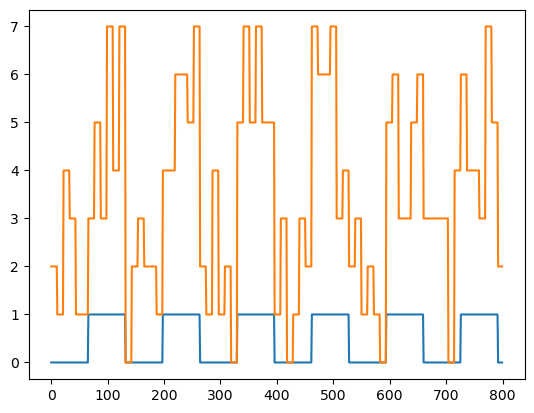

In [ ]:
# plot input data and labels
env.plot(input_class[:800], input_sequence[:800])

(200, 8)


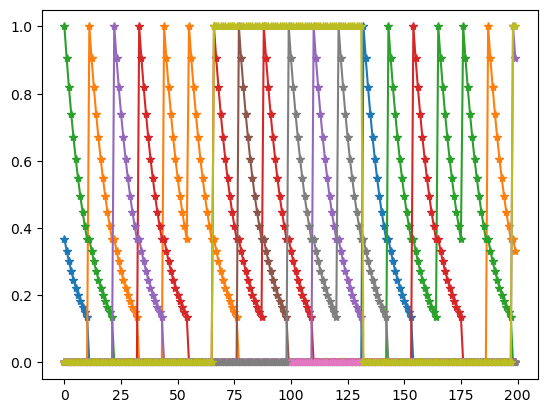

In [ ]:
# plot the encoded data
env.plotSuperposed(input_class[:200], input_sequence[:200])

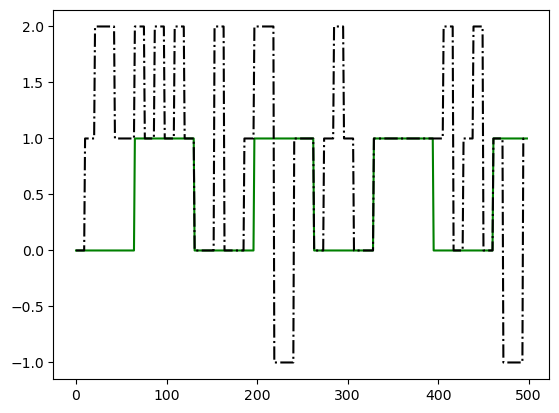

In [ ]:
neuron_group.plotSequence(input_sequence, input_class)

<matplotlib.collections.PathCollection>

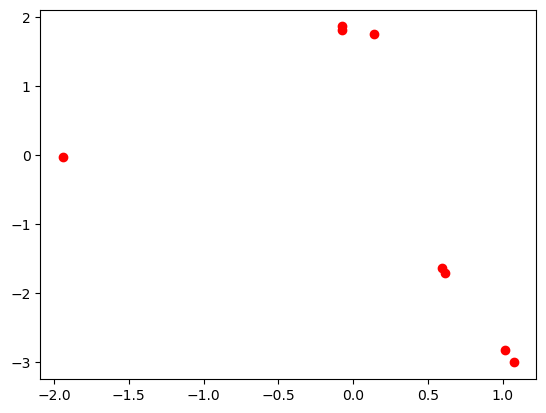

In [ ]:
plt.scatter(neuron_group.syncmap[:, 0], neuron_group.syncmap[:, 1], color = 'red')

In [ ]:
neuron_group.syncmap

array([[ 0.61267149, -1.70094371],
       [ 0.14090266,  1.75214477],
       [ 0.59535774, -1.63006829],
       [ 1.07363382, -3.00289564],
       [ 1.0155888 , -2.81635136],
       [-0.07219065,  1.86674187],
       [-1.94185003, -0.02125776],
       [-0.07227111,  1.8227    ]])

[2.43507734e-03 3.38381385e-03 3.90846920e-03 7.38271356e-09
 6.81023146e-08 1.62000784e-03 9.65156926e-04 2.18489954e-03]


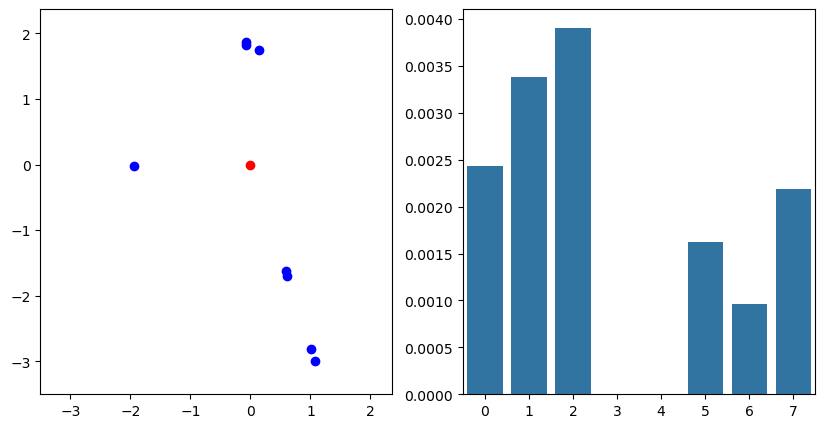

In [ ]:
neuron_group.plot_activity_maps(x = 0, y = 0)

In [ ]:
a = np.around(compute_combi_dist(neuron_group.syncmap), decimals = 4) 
a

array([[0.    , 3.4852, 0.073 , 1.3811, 1.1859, 3.6328, 3.0573, 3.5896],
       [3.4852, 0.    , 3.4126, 4.8457, 4.6515, 0.242 , 2.7355, 0.2245],
       [0.073 , 3.4126, 0.    , 1.4538, 1.2585, 3.56  , 3.0043, 3.5167],
       [1.3811, 4.8457, 1.4538, 0.    , 0.1954, 5.0026, 4.2407, 4.9598],
       [1.1859, 4.6515, 1.2585, 0.1954, 0.    , 4.8078, 4.0693, 4.7649],
       [3.6328, 0.242 , 3.56  , 5.0026, 4.8078, 0.    , 2.6571, 0.044 ],
       [3.0573, 2.7355, 3.0043, 4.2407, 4.0693, 2.6571, 0.    , 2.6259],
       [3.5896, 0.2245, 3.5167, 4.9598, 4.7649, 0.044 , 2.6259, 0.    ]])

In [ ]:
b = np.around(np.exp(-a), decimals = 4)
b

array([[1.    , 0.0306, 0.9296, 0.2513, 0.3055, 0.0264, 0.047 , 0.0276],
       [0.0306, 1.    , 0.033 , 0.0079, 0.0095, 0.7851, 0.0649, 0.7989],
       [0.9296, 0.033 , 1.    , 0.2337, 0.2841, 0.0284, 0.0496, 0.0297],
       [0.2513, 0.0079, 0.2337, 1.    , 0.8225, 0.0067, 0.0144, 0.007 ],
       [0.3055, 0.0095, 0.2841, 0.8225, 1.    , 0.0082, 0.0171, 0.0085],
       [0.0264, 0.7851, 0.0284, 0.0067, 0.0082, 1.    , 0.0702, 0.957 ],
       [0.047 , 0.0649, 0.0496, 0.0144, 0.0171, 0.0702, 1.    , 0.0724],
       [0.0276, 0.7989, 0.0297, 0.007 , 0.0085, 0.957 , 0.0724, 1.    ]])

In [ ]:
pos = np.where(a == a.max())[0]
pos

array([3, 5])

In [ ]:
# a[*pos], b[*pos]

(5.0026, 0.0067)

In [ ]:
# -a[*pos] / np.log(0.0001)

0.543150393792302

In [ ]:
a

array([[0.    , 3.4852, 0.073 , 1.3811, 1.1859, 3.6328, 3.0573, 3.5896],
       [3.4852, 0.    , 3.4126, 4.8457, 4.6515, 0.242 , 2.7355, 0.2245],
       [0.073 , 3.4126, 0.    , 1.4538, 1.2585, 3.56  , 3.0043, 3.5167],
       [1.3811, 4.8457, 1.4538, 0.    , 0.1954, 5.0026, 4.2407, 4.9598],
       [1.1859, 4.6515, 1.2585, 0.1954, 0.    , 4.8078, 4.0693, 4.7649],
       [3.6328, 0.242 , 3.56  , 5.0026, 4.8078, 0.    , 2.6571, 0.044 ],
       [3.0573, 2.7355, 3.0043, 4.2407, 4.0693, 2.6571, 0.    , 2.6259],
       [3.5896, 0.2245, 3.5167, 4.9598, 4.7649, 0.044 , 2.6259, 0.    ]])

In [ ]:
neuron_group.generate_activity_probs()


array([2.43507734e-03, 3.38381385e-03, 3.90846920e-03, 7.38271356e-09,
       6.81023146e-08, 1.62000784e-03, 9.65156926e-04, 2.18489954e-03])

In [ ]:
np.linalg.norm(neuron_group.syncmap, )

6.252357164365741

In [ ]:
r = np.random.rand(5, 5)
a = lower_triangular = np.tril(r, k = -1) + np.tril(r, k = -1).T
a

array([[0.        , 0.28875989, 0.74230583, 0.36653041, 0.52391254],
       [0.28875989, 0.        , 0.12758941, 0.5056331 , 0.23936893],
       [0.74230583, 0.12758941, 0.        , 0.86472982, 0.17829936],
       [0.36653041, 0.5056331 , 0.86472982, 0.        , 0.00879565],
       [0.52391254, 0.23936893, 0.17829936, 0.00879565, 0.        ]])

In [ ]:
b = np.exp(-a)
b

array([[1.        , 0.74919207, 0.47601504, 0.69313506, 0.59219901],
       [0.74919207, 1.        , 0.88021471, 0.60312362, 0.78712444],
       [0.47601504, 0.88021471, 1.        , 0.42116533, 0.83669191],
       [0.69313506, 0.60312362, 0.42116533, 1.        , 0.99124292],
       [0.59219901, 0.78712444, 0.83669191, 0.99124292, 1.        ]])

In [ ]:
pos = np.where(a == a.max())[0]
pos

array([2, 3])

In [ ]:
a[*pos], b[*pos]

(0.8647298201298559, 0.42116532765030235)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()